In [ ]:
# import nltk 
# nltk.download('stopwords')

In [700]:
import pickle

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
import string

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.metrics import silhouette_score

from stemmed_vect import StemmedCountVectorizer, StemmedTfidfVectorizer
from helper import make_silhouette_plot, print_top_words, fit_nmf, print_top_categories, print_centroid_top_words

import pyLDAvis
import pyLDAvis.sklearn

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Text Vectorizer

In [278]:
scv = StemmedCountVectorizer(strip_accents='unicode',
                             stop_words=set(stopwords.words('english')),
                             max_df=0.5,
                             min_df=2,
                             ngram_range=(1, 2),
                             max_features=2000)

stv = StemmedTfidfVectorizer(strip_accents='unicode',
                             stop_words=set(stopwords.words('english')),
                             min_df=2,
                             max_df=0.5,
                             ngram_range=(1, 2),
                             max_features=2000)



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mintleton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [249]:
# with open('scv.model', 'wb') as f:
#     pickle.dump(scv, f)

# with open('stv.model', 'wb') as f:
#     pickle.dump(stv, f)

## Import Data

In [279]:
qadf = pd.read_csv('../data/dearabby_qa.csv', index_col=0)

In [280]:
new_df = qadf[qadf['categories'].notna()]

In [281]:
# new_df = qadf[]

In [480]:
X = new_df['qa']
y = new_df['categories']


In [492]:
X.shape[0]

6703

In [491]:
X.shape[0]/qadf.shape[0]

0.31829621539484304

### Data Visualization

### Text length

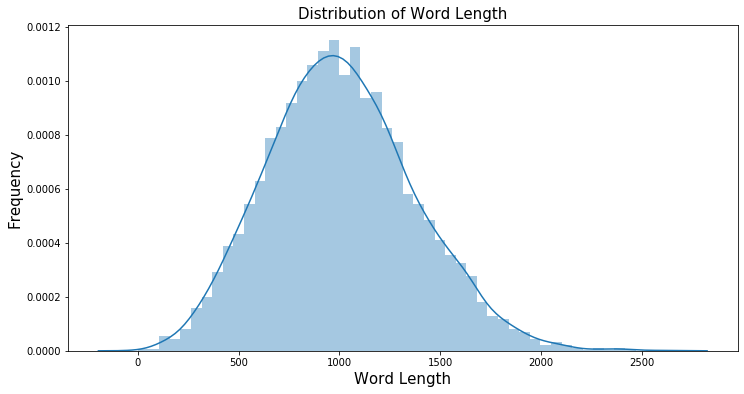

In [441]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.distplot(X.str.len())

ax.set_title('Distribution of Word Length', fontsize=15)
ax.set_xlabel('Word Length', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15);

# fig.savefig('word_length.jpg');

### Mean Character Length

In [442]:
mean_char_len = X.str.split(' ').apply(lambda x: np.mean(list(map(len, x))))

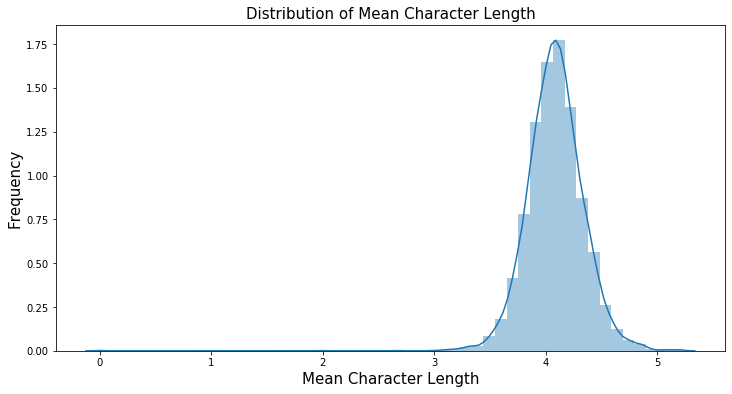

In [443]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.distplot(mean_char_len)

ax.set_title('Distribution of Mean Character Length', fontsize=15)
ax.set_xlabel('Mean Character Length', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15);
# fig.savefig('char_length.jpg');

## Preprocess Text Features into DF and TFIDF

In [481]:
count_x = scv.fit_transform(X)

In [482]:
tfidf_x = stv.fit_transform(X)

## Reduce Dimension for Visualization and Clustering

In [483]:
pca_cv = PCA(n_components=2, random_state=42)
pca_x_cv = pca_cv.fit_transform(count_x.toarray())

In [484]:
pca_tv = PCA(n_components=2, random_state=42)
pca_x_tv = pca_tv.fit_transform(tfidf_x.toarray())

In [250]:
# with open('pca_cv.model', 'wb') as f:
#     pickle.dump(pca_cv, f)
    
# with open('pca_tv.model', 'wb') as f:
#     pickle.dump(pca_tv, f)

## Visualizing KMeans Clusters

### DF Clusters

2
0.39786400957834017
3
0.4245650767211013
4
0.3620418352033546
5
0.36300718588281744
6
0.3516223747181159


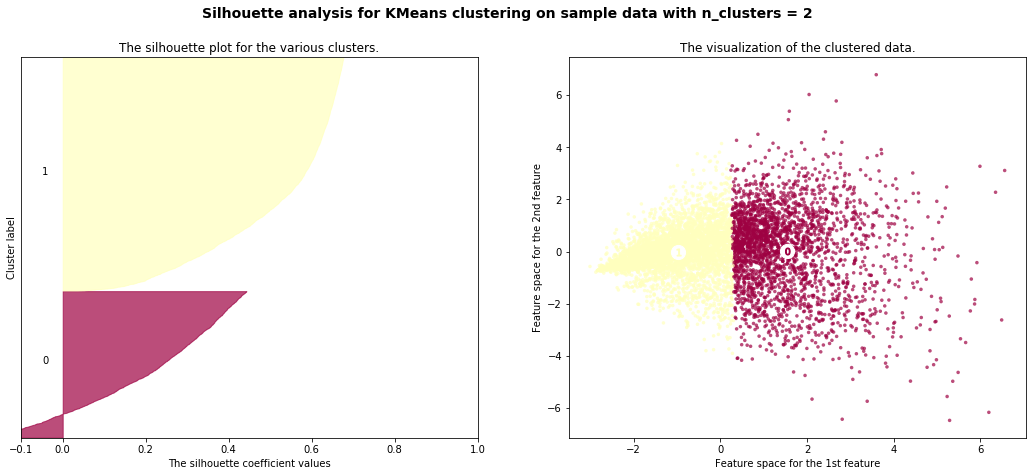

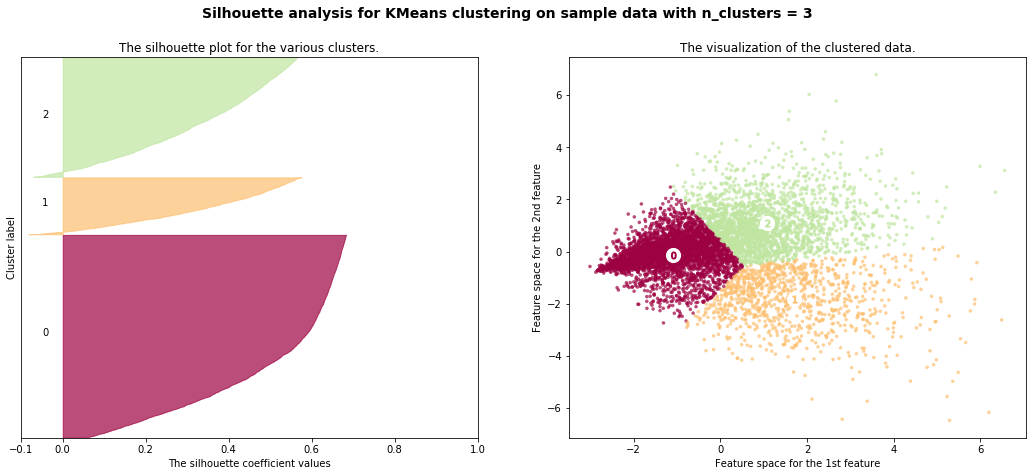

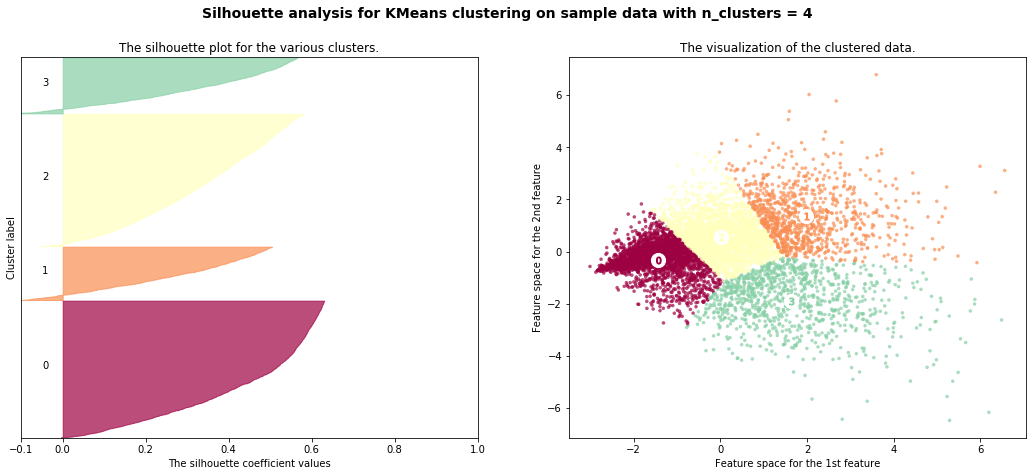

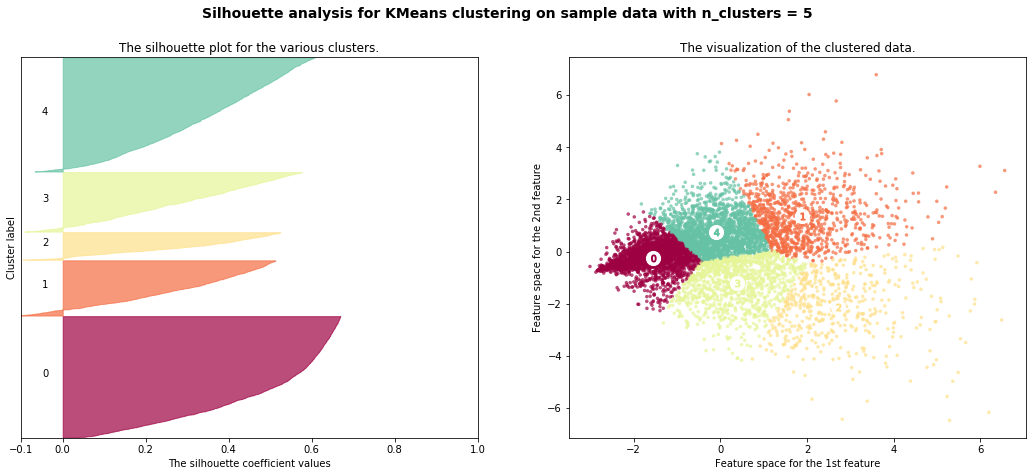

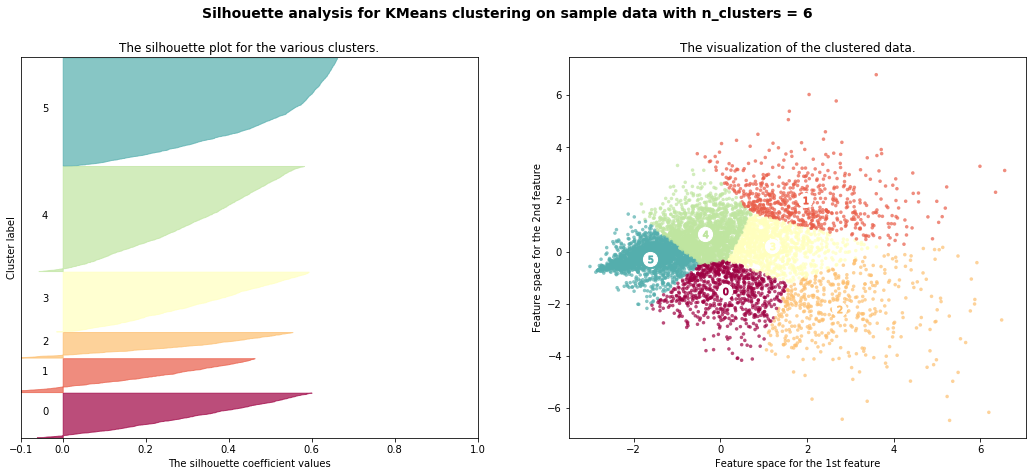

In [448]:
range_n_clusters = range(2, 7)
silhouette_scores_cv = np.empty(shape=5)

for idx, n_clusters in enumerate(range_n_clusters):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    score = make_silhouette_plot(axs, X = pca_x_cv, n_clusters=n_clusters)
    silhouette_scores_cv[idx] = score
    
    print(n_clusters)
    print(score)

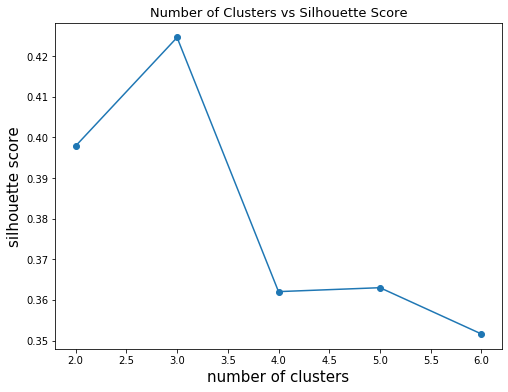

In [493]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range_n_clusters, silhouette_scores_cv, 'o-')
ax.set_xlabel("number of clusters", fontsize=15)
ax.set_ylabel("silhouette score", fontsize=15);
ax.set_title('Number of Clusters vs Silhouette Score', fontsize=13);
# fig.savefig('kmeans_df.jpg');

### Visualizing Clusters' Words (DF)

In [694]:
nclusters = 3

In [695]:
km = KMeans(random_state=42, n_clusters=nclusters, n_jobs=-1)
km.fit(pca_x_cv)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [703]:
original_space_centroids = pca_cv.inverse_transform(km.cluster_centers_)
terms = scv.get_feature_names()

print_centroid_top_words(terms, original_space_centroids, nclusters)


Cluster 0: would friend think like know peopl want feel make tell year help husband famili ask person work daughter need take

Cluster 1: want feel friend would know like year love think famili make tell relationship help live parent life need peopl mother

Cluster 2: husband want year famili would feel know marri children mother help live love daughter marriag think need make tell home



In [676]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(pca_x_cv, km.labels_, sample_size=1000))

print()

Silhouette Coefficient: 0.414



### Comparing Topics To Top 5 Categories in the Clusters

In [698]:
labels = pd.concat([y, pd.Series(km.labels_, index=y.index)], axis=1)

print_top_categories(labels, n_components)

Topic 0:
Family & Parenting    1238
Etiquette & Ethics    1087
Health & Safety        571
dtype: int64

Topic 1:
Family & Parenting     957
Love & Dating          701
Friends & Neighbors    440
dtype: int64

Topic 2:
Marriage & Divorce    593
Family & Parenting    535
Money                 160
dtype: int64

Topic 3:
Series([], dtype: float64)



### TFIDF Clusters

2
0.34104676675931306
3
0.35980272127973
4
0.34865149030644976
5
0.34771162608195366
6
0.3488018774317357


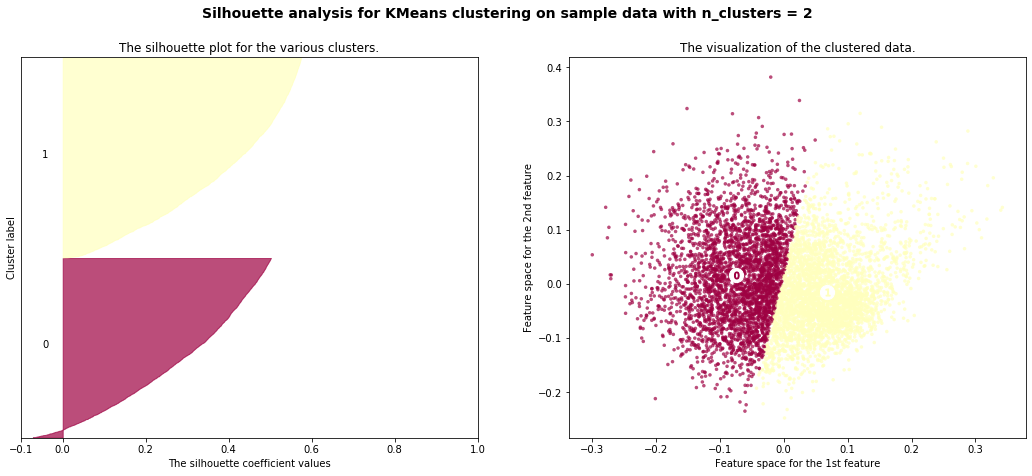

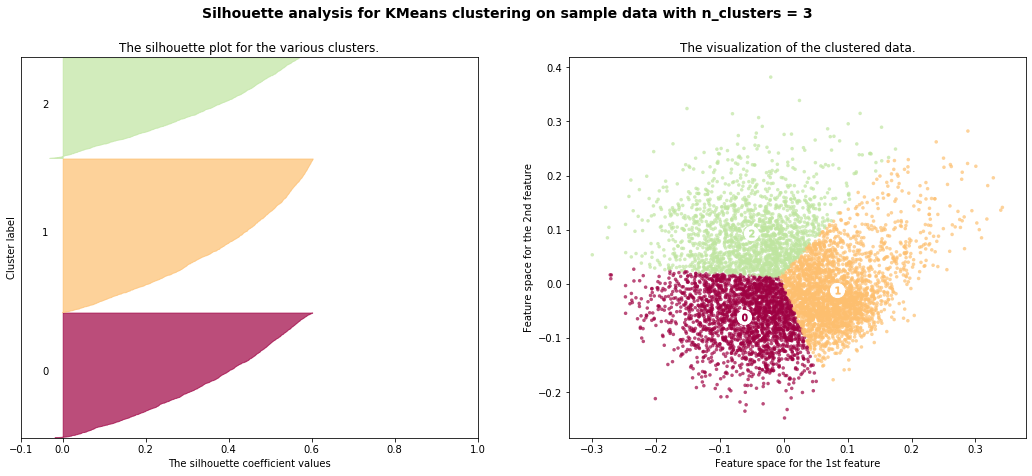

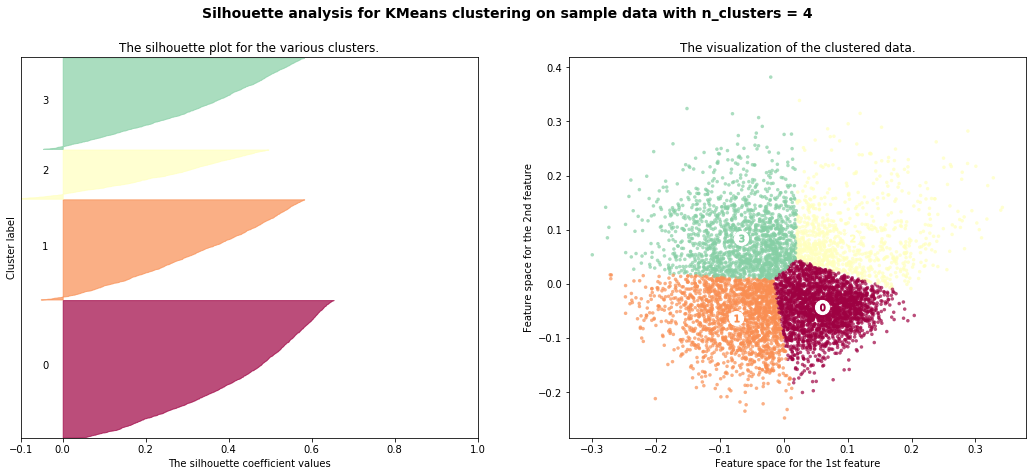

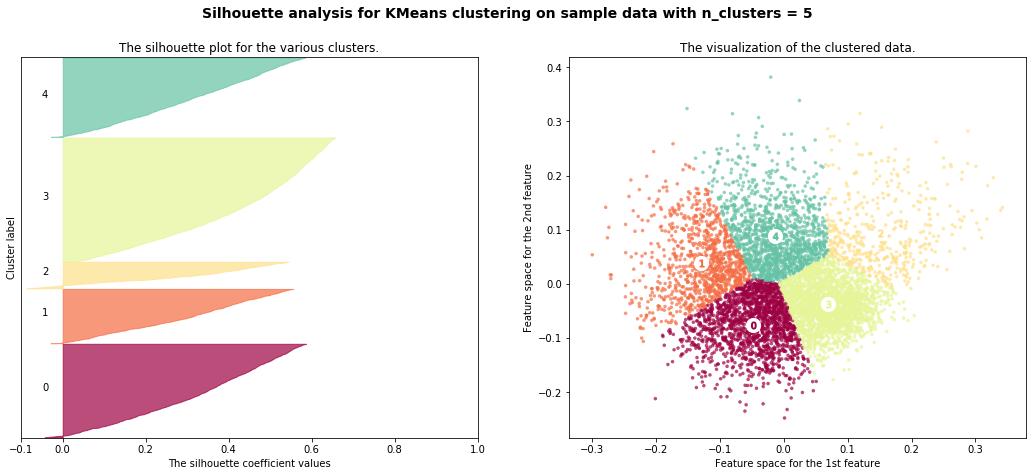

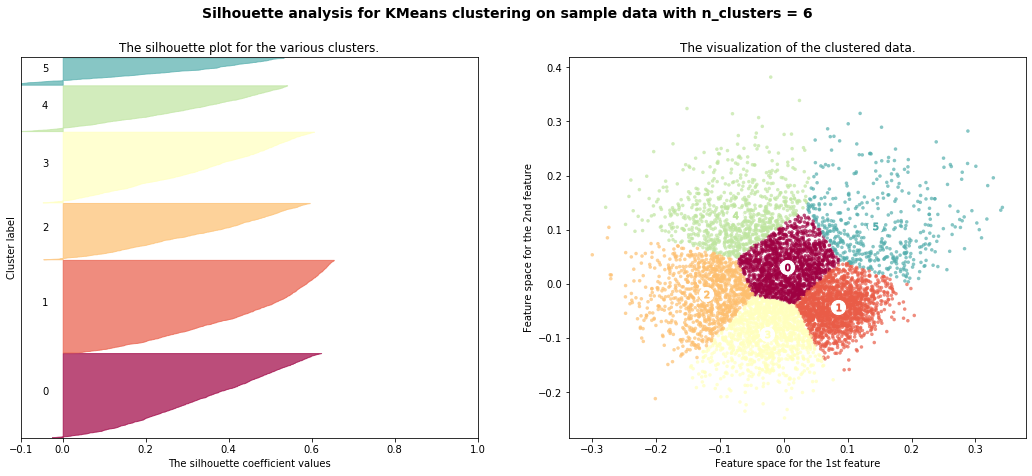

In [463]:
range_n_clusters = range(2, 7)
silhouette_scores_tv = np.empty(shape=5)

for idx, n_clusters in enumerate(range_n_clusters):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    score = make_silhouette_plot(axs, X = pca_x_tv, n_clusters=n_clusters)
    silhouette_scores_tv[idx] = score
    
    print(n_clusters)
    print(score)

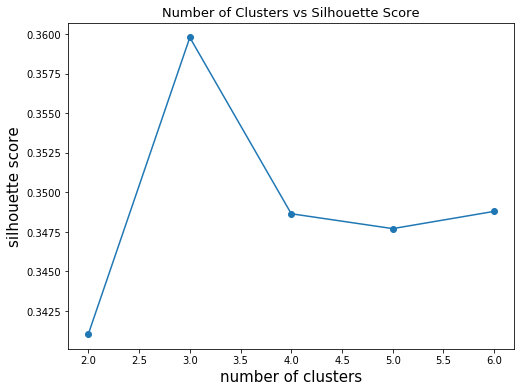

In [494]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range_n_clusters, silhouette_scores_tv, 'o-')
ax.set_xlabel("number of clusters", fontsize=15)
ax.set_ylabel("silhouette score", fontsize=15);
ax.set_title('Number of Clusters vs Silhouette Score', fontsize=13)
# fig.savefig('kmeans_tfidf.jpg');

### Visualizing Clusters' Words (TFIDF)

In [704]:
nclusters = 3

In [705]:
km = KMeans(random_state=42, n_clusters=nclusters, n_jobs=-1)
km.fit(pca_x_tv)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [679]:
# with open('kmeans.model', 'wb') as f:
#     pickle.dump(km, f)

In [706]:
original_space_centroids = pca_tv.inverse_transform(km.cluster_centers_)
terms = stv.get_feature_names()

print_centroid_top_words(terms, original_space_centroids, nclusters)


Cluster 0: friend gift would peopl like think invit person know feel want ask make wed famili tell someon thank work take

Cluster 1: friend want feel year love know relationship husband like would tell help think date talk make life work marri wife

Cluster 2: husband daughter mother famili children want parent year would father sister live wife feel child marri know love help think



In [707]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(pca_x_tv, km.labels_, sample_size=1000))

print()

Silhouette Coefficient: 0.363



### Comparing Topics To Top 5 Categories in the Clusters

In [709]:
labels = pd.concat([y, pd.Series(km.labels_, index=y.index)], axis=1)

print_top_categories(labels, nclusters)

Topic 0:
Etiquette & Ethics     1090
Family & Parenting      769
Friends & Neighbors     512
dtype: int64

Topic 1:
Love & Dating         906
Marriage & Divorce    708
Family & Parenting    487
dtype: int64

Topic 2:
Family & Parenting    1474
Marriage & Divorce     544
Money                  261
dtype: int64



## NMF and LDA Clustering

### NMF Visualization

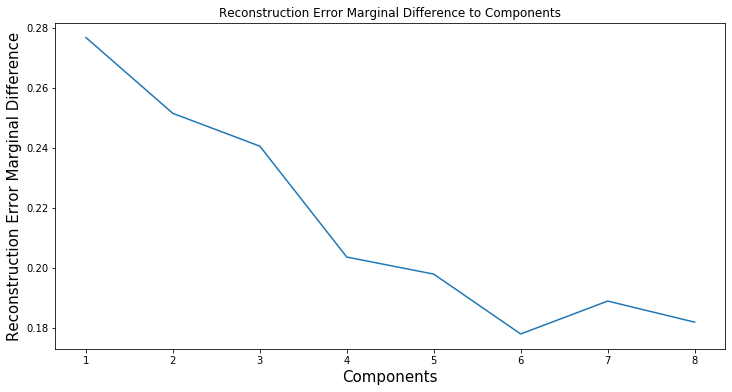

In [502]:
# Compute NMF
nrange = range(1, 10)
error = [fit_nmf(i, tfidf_x) for i in nrange]

fig, ax = plt.subplots(figsize=(12, 6))

# ax.plot(nrange, error)
a = np.array(error)
b = a[1:]


ax.plot(range(1, 9), a[:-1] - b)
ax.set_title('Reconstruction Error Marginal Difference to Components')
ax.set_xlabel('Components', fontsize=15)
ax.set_ylabel('Reconstruction Error Marginal Difference', fontsize=15);
# fig.savefig('recon_err_nmf.jpg');

In [690]:
n_components= 4
n_top_words = 20

### Topic Keywords

In [681]:
nmf = NMF(n_components=n_components, random_state=42,).fit(tfidf_x)

tfidf_feature_names = stv.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: daughter mother parent children famili father child sister live babi brother kid want home help girl would know care visit

Topic #1: gift wed invit parti birthday card would guest thank send attend friend famili dinner receiv celebr give shower note christma

Topic #2: friend feel like peopl know want date relationship person think would tell make someon talk work boyfriend help love thing

Topic #3: husband wife marriag marri year love divorc want togeth feel famili work say counsel would never affair know help think




In [682]:
# with open('nmf.model', 'wb') as f:
#     pickle.dump(nmf, f)

### Top categories in original articles from labels

In [691]:
labels = pd.concat([y, pd.Series(nmf.transform(tfidf_x).argmax(axis=1), index=y.index)], axis=1)

print_top_categories(labels, n_components)

Topic 0:
Family & Parenting    1266
Health & Safety        223
Money                  187
dtype: int64

Topic 1:
Etiquette & Ethics         410
Holidays & Celebrations    389
Family & Parenting         304
dtype: int64

Topic 2:
Love & Dating         968
Family & Parenting    679
Etiquette & Ethics    670
dtype: int64

Topic 3:
Marriage & Divorce    929
Family & Parenting    481
Money                 165
dtype: int64



In [683]:
n_components= 3
n_top_words = 20

### LDA Keywords

In [684]:
lda_cv = LatentDirichletAllocation(n_components=n_components, 
                                   max_iter=5,
                                   learning_method='online',
                                   learning_offset=50.,
                                   random_state=42,
                                   n_jobs=-1)

lda_tf = lda_cv.fit_transform(count_x)
tf_feature_names = scv.get_feature_names()
print_top_words(lda_cv, tf_feature_names, n_top_words)

Topic #0: help know feel want parent like need talk work tell would friend make school think year peopl life relationship find

Topic #1: would like think peopl ask gift friend husband person want make tell call know feel money thank someth someon look

Topic #2: husband want famili year would feel friend live marri wife know love mother like daughter think home togeth make relationship




In [685]:
# with open('lda.model', 'wb') as f:
#     pickle.dump(lda_cv, f)

### Top categories in original articles from labels

In [689]:
labels = pd.concat([y, pd.Series(lda_tf.argmax(axis=1), index=y.index)], axis=1)

print_top_categories(labels, n_components)

Topic 0:
Family & Parenting    932
Love & Dating         626
Health & Safety       548
dtype: int64

Topic 1:
Etiquette & Ethics     829
Family & Parenting     416
Friends & Neighbors    305
dtype: int64

Topic 2:
Family & Parenting    1382
Marriage & Divorce     933
Love & Dating          546
dtype: int64



### pyLDAvis 

In [88]:
pyLDAvis.enable_notebook()

In [654]:
p = pyLDAvis.sklearn.prepare(lda_cv, count_x, scv, R=20)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.037839  0.066995       1        1  39.156792
0     -0.063570 -0.056546       2        1  36.954527
1      0.101409 -0.010449       3        1  23.888681, topic_info=         Term         Freq        Total Category  logprob  loglift
783      gift   879.000000   879.000000  Default  20.0000  20.0000
906   husband  4100.000000  4100.000000  Default  19.0000  19.0000
1957     wife  1918.000000  1918.000000  Default  18.0000  18.0000
1553   school  1153.000000  1153.000000  Default  17.0000  17.0000
1107    marri  1893.000000  1893.000000  Default  16.0000  16.0000
...       ...          ...          ...      ...      ...      ...
1096     make   654.834247  2989.074050   Topic3  -5.1085  -0.0866
1929     want   719.210261  4976.416817   Topic3  -5.0147  -0.5025
1016     know   611.314518  4100.214956   Topic3  -5.1773  -0.4714
693      feel   609.984039  4432.506466   Topic3  -5.1794  -0.5515
1659   someon   514.308918  1587.082918   Topic3  -5.3500   0.3049

[191 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5         1  0.014047        abus
5         2  0.985049        abus
5         3  0.001756        abus
18        1  0.030798  acknowledg
18        2  0.007700  acknowledg
...     ...       ...         ...
1983      2  0.249786       would
1983      3  0.272739       would
1992      1  0.634812        year
1992      2  0.280313        year
1992      3  0.084783        year

[379 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [671]:
# pyLDAvis.save_html(p, 'lda.html')

In [710]:
# from wordcloud import WordCloud, STOPWORDS

# def filter_3_len(row):
#     return list(filter(lambda x: len(x) > 3, row))

# ### Cluster 0

# wordcloud_text = X[km.labels_ == 0]
# wordcloud_text = wordcloud_text.str.replace('[.?,!()]', '')
# wordcloud_text = wordcloud_text.str.split(' ').apply(filter_3_len).str.join(' ')
# wordcloud_text = ' '.join(wordcloud_text.to_list())

# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=STOPWORDS).generate(wordcloud_text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# ### Cluster 1

# wordcloud_text = X[km.labels_ == 1]
# wordcloud_text = wordcloud_text.str.replace('.?!', '')
# wordcloud_text = wordcloud_text.str.split(' ').apply(filter_3_len).str.join(' ')
# wordcloud_text = ' '.join(wordcloud_text.to_list())

# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=STOPWORDS).generate(wordcloud_text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# ### Cluster 2

# wordcloud_text = X[km.labels_ == 2]
# wordcloud_text = wordcloud_text.str.replace('.?!', '')
# wordcloud_text = wordcloud_text.str.split(' ').apply(filter_3_len).str.join(' ')
# wordcloud_text = ' '.join(wordcloud_text.to_list())

# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=STOPWORDS).generate(wordcloud_text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()